In [69]:
!pip install -r requirements.txt

  Using cached numpy-1.19.3-cp38-cp38-manylinux2010_x86_64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [74]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from numpy import dot
from numpy.linalg import norm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os, cv2

# 특징 추출할때 사용할 모델 선택
def setModel(model):
    if (model == 'VGG16'):
        model = VGG16(weights='imagenet')
        model = Model(inputs=model.input, outputs=model.get_layer('fc1').output)
    elif (model == 'InceptionV3'):
        model = InceptionV3(weights='imagenet')
        model = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)
    elif (model == 'EfficientNetB0'):
        model = EfficientNetB0(weights='imagenet')
        model = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)
    elif (model == 'ResNet50'):
        model = ResNet50(weights='imagenet')
        model = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)
    else:
        print('{} 모델은 없거나 지원하지 않습니다.'.format(model))
    
    return model
    
# 이미지에서 특성 추출
def feature_extractor(model, img):
    img = Image.open(img)
    img = img.resize((model.input.shape[1], model.input.shape[2]))
    img = img.convert('RGB')
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    feature = model.predict(x)[0]
    return feature / np.linalg.norm(feature)

# 비디오로 데이터베이스를 만들고 싶을때
def extractFrame(video):
    vid = cv2.VideoCapture('./{}.mp4'.format(video))
    count = 0
    
    if not os.path.exists(video):
        os.mkdir('./{}'.format(video))
    
    while True:
        ret, image = vid.read()
        
        if (int(vid.get(1)) % 30 == 0):
            cv2.imwrite('./{}/'.format(video) + '{}.jpg'.format(count), image)
            count += 1
            
        if not ret:
            break
            
    vid.release()

# 특정 디렉토리 내의 이미지들 경로를 추출
def setImageDB_li(dirName):
    imageDB_li = os.listdir('./{}/'.format(dirName))
    imageDB_li = [os.getcwd() + '/{}/'.format(dirName) + image for image in imageDB_li]
    
    return imageDB_li

# 이미지 데이터베이스에서 특징을 추출하여 *.npy 형식으로 추출
def getImageDB(imageDB_li, dirName):
    if not os.path.exists(dirName + '_npy'):
        os.mkdir('./{}_npy'.format(dirName))
    for img in sorted(imageDB_li):
        feature = feature_extractor(model, img)

        feature_path = './{}_npy/'.format(dirName) + img.split('/')[-1].split('.')[0] + '.npy'
        np.save(feature_path, feature)

# 코사인 유사도
def cos_sim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

# 유클리디언 유사도
def euclidean(features, query):
    return np.linalg.norm(features - query, axis=1)

def getFeatureAndPath(dirName):
    features = []
    img_path = []
    for img_npy in Path('./{}_npy/'.format(dirName)).glob('*.npy'):
        features.append(np.load(img_npy))
        img_path.append(os.path.join('./{}/'.format(dirName), img_npy.stem + '.jpg'))
        
    return features, img_path
        
# 유클리디언 유사도 계산
def calc_euclienan(features, img_path, src):
    query = feature_extractor(model, src)
    result = euclidean(features, query)
    
    ids = np.argsort(result)[:27]
    print(len(ids))
    scores = [(result[id], img_path[id]) for id in ids]
    
    draw_graph(result, scores, 'eunc')

# 코사인 유사도 계산
def calc_cossim(features, img_path, src):
    query = feature_extractor(model, src)
    result = []
    for feature in features:
        result.append(cos_sim(feature, query))

    ids = np.argsort(result)[-27:]
    print(len(ids))
    scores = [(result[id], img_path[id]) for id in ids]
    
    draw_graph(result, scores, 'cos')
    
# 그래프를 그림
def draw_graph(result, scores, title):
    axes=[]
    fig=plt.figure(figsize=(24,24))
    plt.title(title)

    for a in range(len(scores)):
        score = scores[a]
        axes.append(fig.add_subplot(9, 3, a+1))
        subplot_title=str(score[0])
        axes[-1].set_title(subplot_title)  
        plt.axis('off')
        img = Image.open(score[1])
        plt.imshow(img)

    fig.tight_layout()
    plt.show()

27


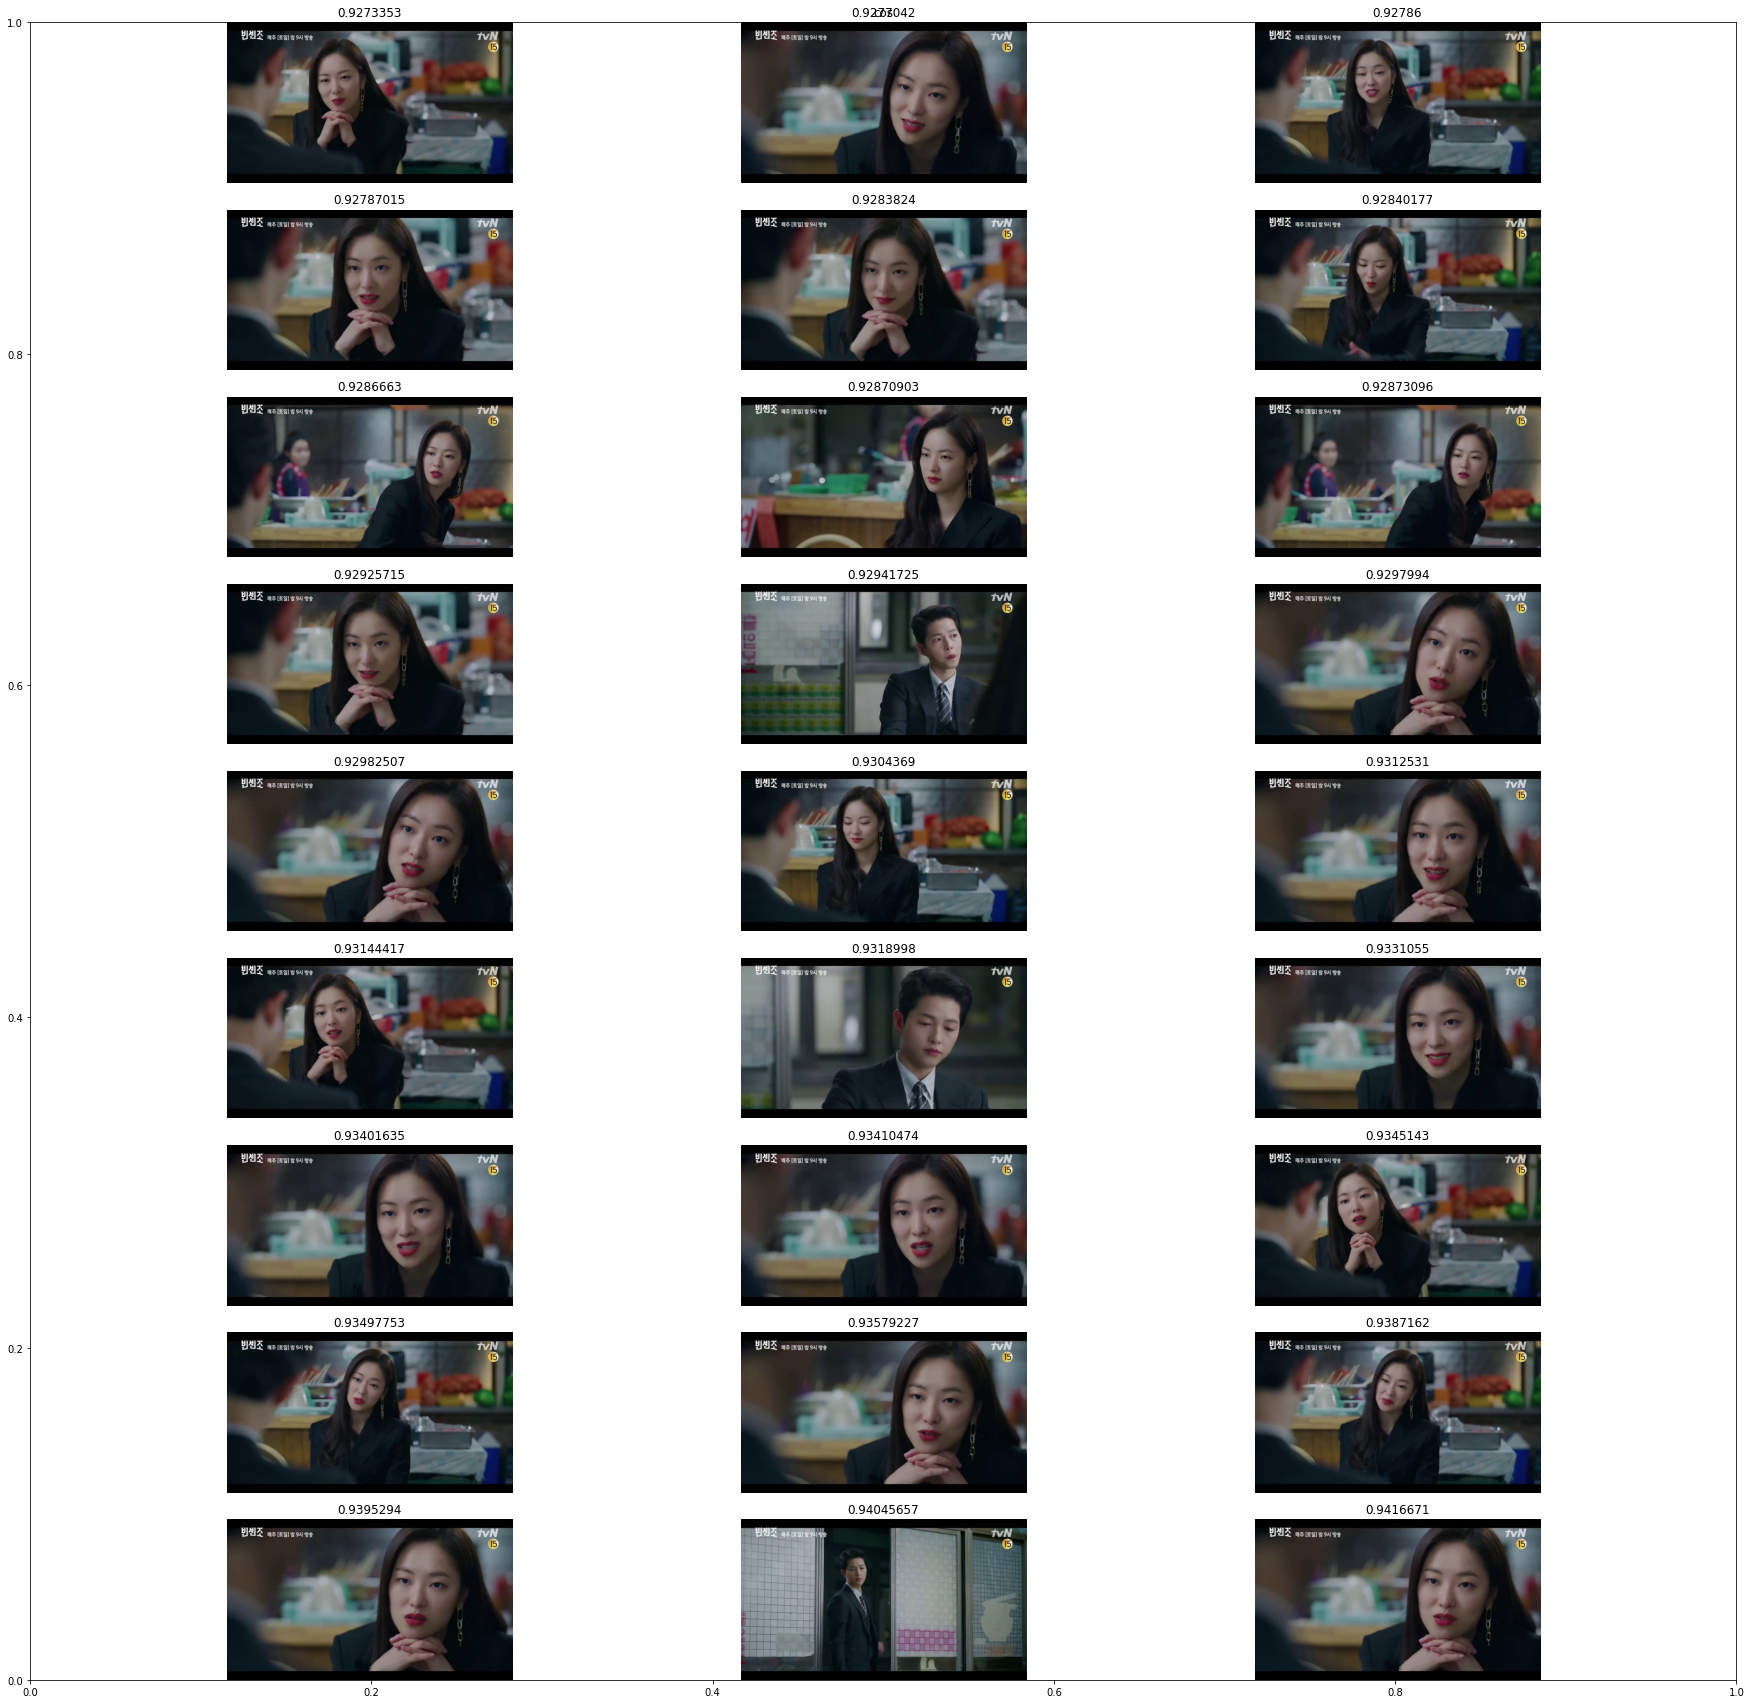

27


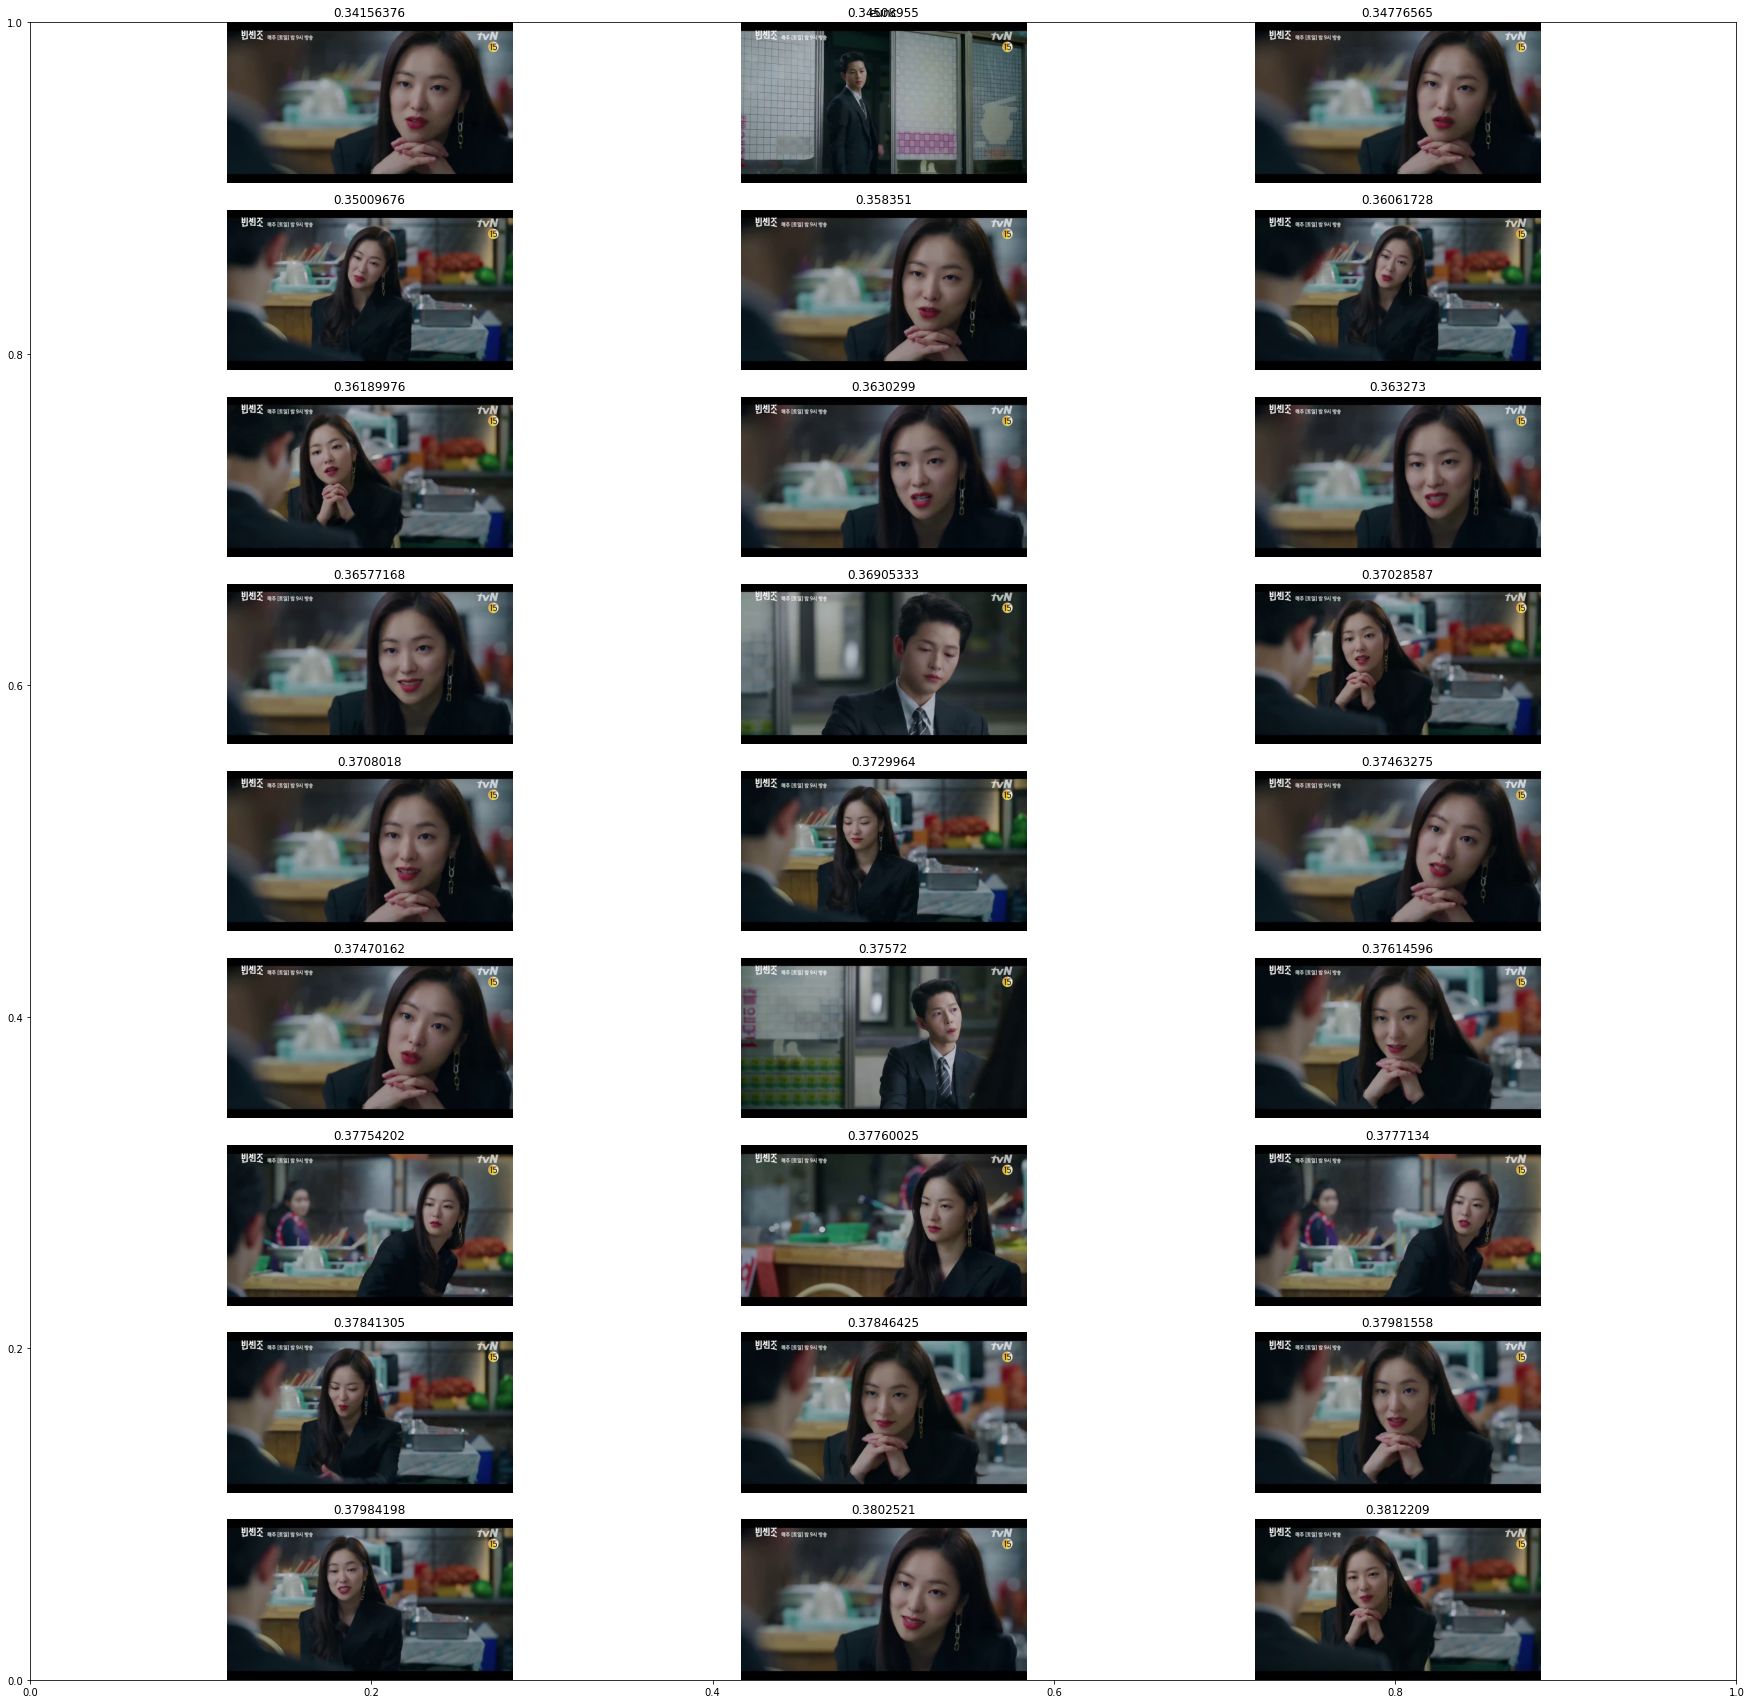

In [77]:
model = setModel('InceptionV3')
extractFrame('vincenzo')

getImageDB(setImageDB_li('vincenzo'), 'vincenzo')
features, img_path = getFeatureAndPath('vincenzo')
calc_cossim(features, img_path, './song.jpg')
calc_euclienan(features, img_path, './song.jpg')